# Notebook 00: Build model features for 2009 SCPC

## Summary

This notebook contains the code to subset and cleanse the 2009 Survey of Consumer Payment Choice specifically for replicating the analysis found in my 2012 study ["Conditions for Consumer Acceptance of Mobile Payment Methods In the United States."](https://github.com/sedelmeyer/mobile-payment-adoption/blob/master/Sedelmeyer_MobilePayment_20120503.pdf)

## Input

The original raw dataset cleansed in this notebook and used for the resulting feature set is the Federal Reserve Bank of Boston's 2009 Survey of Consumer Payment Choice. While it appears that the original .dta file is no longer available on the BOS FED's website, the original source URL for that data was: http://www.bos.frb.org/economic/cprc/SCPC/index.htm

## Output

The resulting datasets generated with this notebook are saved to the `../data/processed` directory found in this project repository and titled:

1. `model-data-mobile-payment.csv`: The cleansed dataset, saved as a complete set with all observations included

2. `model-data-train.csv`: The cleansed dataset training set, representing 60% of the total observations, stratified by the response variables `MPay`

3. `model-data-test.csv`: The cleansed dataset test set, representing 40% of the total observations, stratified by the response variables `MPay`


<a id='top'></a>

## Contents

This notebook is separated into the following sections:

1. [Read and subset data](#read)
1. [Recode "Payment" variables and delete null value observations](#pay)
1. [Recode and combine "Education Level" variables and create value labels](#edu)
1. [Recode and combine "Income Level" variables and create value labels](#inc)
1. [Recode and combine "Age" variables and create value labels](#age)
1. [Recode "White" variable and create value labels](#race)
1. [Reorder columns](#cols)
1. [Save cleansed model data for EDA and modeling](#save)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
DATA_ROOT = "../data/"
READDIR_ROOT = os.path.join(DATA_ROOT, 'raw')
WRITEDIR_ROOT = os.path.join(DATA_ROOT, 'processed')

# FIGURES_ROOT = '../docs/_static/figures/'

readfile = os.path.join(READDIR_ROOT, 'SCPC2009.csv')

print(readfile)

../data/raw/SCPC2009.csv


<a id='read'></a>

# Read and subset data

[return to top](#top)

In [3]:
df_scpc = pd.read_csv(readfile, low_memory=False)

df_scpc.info()
df_scpc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2173 entries, 0 to 2172
Columns: 1650 entries, Unnamed: 0 to rating_security
dtypes: float64(1377), int64(255), object(18)
memory usage: 27.4+ MB


,Unnamed: 0,prim_key,internetlocation,familyincome,birthmonth,birthday,birthyear,cellphone,fr001_a,fr001_b,...,csh_house_no_mon_t_y,csh_freq_no_mon_t_y,csh_total_no_mon_t_y,csh_month_no_mon_t_y,csh_amnt_no_mon_t_y,de016_ho,rating_acceptance,rating_cost,rating_convenience,rating_security
0,0,2011016:1,1.0,4.0,12.0,10.0,52.0,1.0,5.0,5.0,...,100.0,2.000000,130.0,200.000000,100.0,20.0,2.0,1.0,3.0,4.0
1,1,2011018:1,1.0,11.0,12.0,24.0,44.0,1.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0,4.0
2,2,2011018:2,1.0,10.0,11.0,23.0,38.0,1.0,2.0,1.0,...,3.0,4.348214,37.0,173.928574,40.0,NaN,4.0,4.0,4.0,4.0
3,3,2011041:1,2.0,14.0,11.0,20.0,45.0,1.0,3.0,2.0,...,200.0,2.000000,260.0,120.000000,60.0,400.0,2.0,4.0,3.0,1.0
4,4,2011042:1,1.0,14.0,4.0,8.0,57.0,1.0,3.0,2.0,...,250.0,4.348214,450.0,869.642883,200.0,100.0,1.0,3.0,2.0,4.0


In [4]:
subset_cols = [
    'r_weight','pa051_a','pa051_b','pa027_a',
    'pa027_b','pa027_c','pa027_d','pa027_e',
    'pa026','age','edu_lhs','edu_hs','edu_sc',
    'edu_c','edu_pgs','inc_lt25','inc_2549',
    'inc_5074','inc_7599','inc_100124','inc_125199',
    'inc_gt200','white'
]

df_scpc = df_scpc[subset_cols]
df_scpc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2173 entries, 0 to 2172
Data columns (total 23 columns):
r_weight      2173 non-null float64
pa051_a       1974 non-null float64
pa051_b       1975 non-null float64
pa027_a       2158 non-null float64
pa027_b       2157 non-null float64
pa027_c       2157 non-null float64
pa027_d       2158 non-null float64
pa027_e       2157 non-null float64
pa026         1888 non-null float64
age           2172 non-null float64
edu_lhs       2173 non-null int64
edu_hs        2173 non-null int64
edu_sc        2173 non-null int64
edu_c         2173 non-null int64
edu_pgs       2173 non-null int64
inc_lt25      2167 non-null float64
inc_2549      2167 non-null float64
inc_5074      2167 non-null float64
inc_7599      2167 non-null float64
inc_100124    2167 non-null float64
inc_125199    2167 non-null float64
inc_gt200     2167 non-null float64
white         2173 non-null int64
dtypes: float64(17), int64(6)
memory usage: 390.6 KB


In [5]:
df_scpc.describe()

,r_weight,pa051_a,pa051_b,pa027_a,pa027_b,pa027_c,pa027_d,pa027_e,pa026,age,...,edu_c,edu_pgs,inc_lt25,inc_2549,inc_5074,inc_7599,inc_100124,inc_125199,inc_gt200,white
count,2173.000000,1974.000000,1975.000000,2158.000000,2157.000000,2157.000000,2158.000000,2157.000000,1888.000000,2172.000000,...,2173.00000,2173.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2167.000000,2173.000000
mean,45.897377,1.983283,1.991392,1.904541,1.924896,1.986555,1.899444,1.980529,1.902542,50.891805,...,0.26277,0.207547,0.135210,0.257960,0.251038,0.157360,0.072912,0.085371,0.040148,0.876208
std,57.027656,0.128243,0.092400,0.293916,0.263621,0.115195,0.300810,0.138207,0.296658,14.206991,...,0.44024,0.405644,0.342027,0.437613,0.433711,0.364224,0.260052,0.279498,0.196351,0.329420
min,10.189878,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.266010,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,41.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,26.607519,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,52.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.907169,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,61.000000,...,1.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,776.699219,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,90.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df_scpc.head()

,r_weight,pa051_a,pa051_b,pa027_a,pa027_b,pa027_c,pa027_d,pa027_e,pa026,age,...,edu_c,edu_pgs,inc_lt25,inc_2549,inc_5074,inc_7599,inc_100124,inc_125199,inc_gt200,white
0,48.407444,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,56.0,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,19.693514,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,64.0,...,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,27.521273,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,70.0,...,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,21.771318,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,63.0,...,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,12.004013,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,52.0,...,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


<a id="recode"></a>

# Recode Variables

<a id='pay'></a>

## Recode "Payment" variables and delete null value observations

[return to top](#top)

**(PA027)** A **contactless payment technology** allows the consumer to make a payment by tapping or waving a card or other instrument near a special electronic reading device without swiping, signing or entering a personal identification number.

Do you have any of the following payment methods with contactless payment technology?

| Variable    | Description 
|:-------|:---------
|pa027_a | Credit card
|pa027_b | Debit card
|pa027_c | Prepaid card
|pa027_d | Electronic toll payment
|pa027_e | Key fob

#### Conditional payment variables for cell phone adopters (CPADOPTER)

Survey respondents were also asked the following question:

**(cellphone)** Do you have a cell phone?

Only ff they answered "yes" to this (i.e. CPADOPTER = 1), they were asked the following several questions:

**Mobile banking** uses a mobile device to access your bank account. This can be done
either by accessing your bank’s web page through the web browser on your mobile
device, via text messaging or SMS, or by using a downloadable application on your
mobile device.

Have you set up any of the following methods of accessing your current bank accounts?

| Variable    | Description
|:-------|:---------
|pa026   | Mobile banking


**(PA051)** **Mobile payments** are payments or purchases made using a mobile phone. These
payments do not involve transactions with your bank or financial institution.

In the past 12 months, have you made any of the following types of mobile payments?

| Variable    | Description
|:-------|:---------
|pa051_a |Payment made using text message in past 12 months
|pa051_b |Contactless payment via tapping or waving your phone


In [7]:
def var_summary(dataframe, varcol, var_labelcol, verbose=True):
    """
    Generates summary dataframe showing variable response values, labels and counts
    
    Args:
        dataframe (pd.DataFrame): dataframe containing data to summarize
        varcol (str): name of column with class values
        var_labelcol (str): name of column with class names
        verbose (bool): if True, prints df_summary, default=True
    
    Returns:
        df_summary (pd.DataFrame): variable summary dataframe
    """
    agg_dict = {varcol: 'count'}
    df_summary = dataframe.groupby([varcol, var_labelcol]).agg(
        agg_dict
    ).rename(columns=agg_dict)
    
    if verbose:
        print(df_summary)
    
    return df_summary

In [8]:
pa_col_list = [
    'pa051_a','pa051_b','pa027_a','pa027_b',
    'pa027_c','pa027_d','pa027_e', 'pa026'
]

In [9]:
# Count null values per variable
df_scpc[pa_col_list].isnull().sum()

pa051_a    199
pa051_b    198
pa027_a     15
pa027_b     16
pa027_c     16
pa027_d     15
pa027_e     16
pa026      285
dtype: int64

In [10]:
# Count response values per variable
#     2 = No
#     1 = Yes
print(df_scpc[pa_col_list].apply(pd.Series.value_counts))

     pa051_a  pa051_b  pa027_a  pa027_b  pa027_c  pa027_d  pa027_e  pa026
2.0     1941     1958     1952     1995     2128     1941     2115   1704
1.0       33       17      206      162       29      217       42    184


In [11]:
# Delete null observations
# Recode 'No' response from 2 to 0
for i in pa_col_list:
    df_scpc[i] = df_scpc[i].replace(2,0)
    df_scpc = df_scpc.copy().dropna(subset=[i])

In [12]:
# Summarize response count with null observations deleted
print(df_scpc[pa_col_list].apply(pd.Series.value_counts))

     pa051_a  pa051_b  pa027_a  pa027_b  pa027_c  pa027_d  pa027_e  pa026
0.0     1850     1863     1699     1735     1855     1681     1839   1697
1.0       28       15      179      143       23      197       39    181


In [13]:
# Confirm removal of all null observations
print(df_scpc[pa_col_list].isnull().sum())

pa051_a    0
pa051_b    0
pa027_a    0
pa027_b    0
pa027_c    0
pa027_d    0
pa027_e    0
pa026      0
dtype: int64


## Combine payment variables by type (Mobile vs Contactless) and add value labels

In [14]:
# Consolidate mobile payment variables and inspect repsonse counts
df_scpc['MPay'] = df_scpc[pa_col_list[:2]].sum(axis=1)
df_scpc['MPay'].value_counts()

0.0    1838
1.0      37
2.0       3
Name: MPay, dtype: int64

In [15]:
# Recode all mobile payment "yes" responses to 1

binary_label_dict = {
    0: 'No',
    1: 'Yes'
}

df_scpc['MPay'] = df_scpc['MPay'].replace(to_replace=2,value=1).astype(int)
df_scpc['MPay_label'] = df_scpc['MPay'].map(binary_label_dict)

# confirm results
MPay_summary = var_summary(df_scpc, 'MPay', 'MPay_label')

                 count
MPay MPay_label       
0    No           1838
1    Yes            40


In [16]:
# Consolidate contactless payment variables
df_scpc['CPay'] = df_scpc[pa_col_list[2:-1]].sum(axis=1)

df_scpc['CPay'].value_counts()

0.0    1439
1.0     333
2.0      80
3.0      21
5.0       5
Name: CPay, dtype: int64

In [17]:
# Recode all contactless payment "yes" responses to 1
df_scpc.loc[df_scpc['CPay'] >= 1, 'CPay'] = 1
df_scpc['CPay'] = df_scpc['CPay'].astype(int) 
df_scpc['CPay_label'] = df_scpc['CPay'].map(binary_label_dict)

# confirm results
CPay_summary = var_summary(df_scpc, 'CPay', 'CPay_label')

                 count
CPay CPay_label       
0    No           1439
1    Yes           439


## Duplicate Mobile Banking variable and add value labels

In [18]:
df_scpc['MBank'] = df_scpc['pa026'].astype(int)
df_scpc['MBank_label'] = df_scpc['MBank'].map(binary_label_dict)

# confirm results
MBank_summary = var_summary(df_scpc, 'MBank', 'MBank_label')

                   count
MBank MBank_label       
0     No            1697
1     Yes            181


<a id='edu'></a>

## Recode and combine "Education Level" variables and create value labels

[return to top](#top)

**(edu)** **Demographic variables**

| Variable    | Description
|:-------|:---------
|edu_lhs |Education: less than high school (Y/N)
|edu_hs |Education: high school (Y/N)
|edu_sc |Education: some college (Y/N)
|edu_c |Education: college (Y/N)
|edu_pgs |Education: post-graduate studies (Y/N)

In [19]:
ed_col_list = [
    'edu_lhs', 'edu_hs', 'edu_sc', 'edu_c', 'edu_pgs'
]

In [20]:
# Recode and print response counts for each ed_col_list variable
# based on education levels 1-5
for i in ed_col_list:
    df_scpc.loc[df_scpc[i] == 1, i] = ed_col_list.index(i) + 1
    print(df_scpc[i].value_counts())

0    1848
1      30
Name: edu_lhs, dtype: int64
0    1619
2     259
Name: edu_hs, dtype: int64
0    1211
3     667
Name: edu_sc, dtype: int64
0    1361
4     517
Name: edu_c, dtype: int64
0    1473
5     405
Name: edu_pgs, dtype: int64


In [21]:
# Consolidate ed_col_list variables into single EdLevel column
df_scpc['EdLevel'] = df_scpc[ed_col_list].sum(axis=1)
    
# Confirm results
df_scpc['EdLevel'].value_counts().sort_index()

1     30
2    259
3    667
4    517
5    405
Name: EdLevel, dtype: int64

In [22]:
# Create corresponding EdLevel value descriptions
edlevel_label_dict = {
    1: 'Less than High School',
    2: 'High School',
    3: 'Some College',
    4: 'College',
    5: 'Post-graduate Studies',
}

df_scpc['EdLevel_label'] = df_scpc['EdLevel'].map(edlevel_label_dict)

# Confirm results
EdLevel_summary = var_summary(df_scpc, 'EdLevel', 'EdLevel_label')

                               count
EdLevel EdLevel_label               
1       Less than High School     30
2       High School              259
3       Some College             667
4       College                  517
5       Post-graduate Studies    405


<a id='inc'></a>

## Recode and combine "Income Level" variables and create value labels

[return to top](#top)

**(inc)** **Demographic variables**

| Variable    | Description
|:-------|:---------
|inc_lt25 |Household income: under \$25,000 per year (Y/N)
|inc_2549 |Household income: \$25,000-49,999 per year (Y/N)
|inc_5074 |Household income: \$50,000-74,999 per year (Y/N)
|inc_7599 |Household income: \$75,000-99,999 per year (Y/N)
|inc_100124 |Household income: \$100,000-124,999 per year (Y/N)
|inc_125199 |Household income: \$125,000-199,999 per year (Y/N)
|inc_gt200 |Household income: Greater than \$200,000 per year (Y/N)

In [23]:
inc_col_list = [
    'inc_lt25','inc_2549','inc_5074','inc_7599',
    'inc_100124','inc_125199','inc_gt200'
]

In [24]:
# Recode and print response counts for each inc_col_list variable
# based on income levels 1-7
for i in inc_col_list:
    df_scpc.loc[df_scpc[i] == 1, i] = inc_col_list.index(i) + 1
    print(df_scpc[i].value_counts(dropna=False))

0.0    1677
1.0     196
NaN       5
Name: inc_lt25, dtype: int64
0.0    1402
2.0     471
NaN       5
Name: inc_2549, dtype: int64
0.0    1390
3.0     483
NaN       5
Name: inc_5074, dtype: int64
0.0    1559
4.0     314
NaN       5
Name: inc_7599, dtype: int64
0.0    1726
5.0     147
NaN       5
Name: inc_100124, dtype: int64
0.0    1697
6.0     176
NaN       5
Name: inc_125199, dtype: int64
0.0    1787
7.0      86
NaN       5
Name: inc_gt200, dtype: int64


In [25]:
# confirm all income level columns share the same non-response obs
df_scpc.loc[df_scpc['inc_2549'].isnull()][inc_col_list]

,inc_lt25,inc_2549,inc_5074,inc_7599,inc_100124,inc_125199,inc_gt200
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2031,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# inspect other columns response values for obs with missing inc data
df_scpc.loc[df_scpc['inc_2549'].isnull()].drop(
    [*inc_col_list, *ed_col_list, *pa_col_list], axis=1
)

,r_weight,age,white,MPay,MPay_label,CPay,CPay_label,MBank,MBank_label,EdLevel,EdLevel_label
87,19.537546,65.0,1,0,No,0,No,0,No,5,Post-graduate Studies
1048,20.304874,52.0,1,0,No,0,No,0,No,3,Some College
1206,36.589474,25.0,1,0,No,0,No,0,No,3,Some College
1820,17.837114,62.0,1,0,No,0,No,0,No,3,Some College
2031,154.424210,37.0,1,0,No,1,Yes,0,No,2,High School


In [27]:
# drop obs with missing income values rather than trying to impute
for i in inc_col_list:
    df_scpc = df_scpc.copy().dropna(subset=[i])
    print(df_scpc[i].value_counts(dropna=False))

0.0    1677
1.0     196
Name: inc_lt25, dtype: int64
0.0    1402
2.0     471
Name: inc_2549, dtype: int64
0.0    1390
3.0     483
Name: inc_5074, dtype: int64
0.0    1559
4.0     314
Name: inc_7599, dtype: int64
0.0    1726
5.0     147
Name: inc_100124, dtype: int64
0.0    1697
6.0     176
Name: inc_125199, dtype: int64
0.0    1787
7.0      86
Name: inc_gt200, dtype: int64


In [28]:
# Confirm no null value counts
df_scpc[inc_col_list].isnull().sum()

inc_lt25      0
inc_2549      0
inc_5074      0
inc_7599      0
inc_100124    0
inc_125199    0
inc_gt200     0
dtype: int64

In [29]:
# Consolidate all inc_col_list variables into single column
df_scpc['IncLevel'] = df_scpc[inc_col_list].sum(axis=1).astype(int)
    
df_scpc['IncLevel'].value_counts().sort_index()

1    196
2    471
3    483
4    314
5    147
6    176
7     86
Name: IncLevel, dtype: int64

In [30]:
# Create corresponding income level category names
inclevel_label_dict = {
    1: "Less than $25,000",
    2: "$25,000-$49,999 per year",
    3: "$50,000-$74,999 per year",
    4: "$75,000-$99,999 per year",
    5: "$100,000-$124,999 per year",
    6: "$125,000-$199,999 per year",
    7: "Greater than $200,000 per year"
}

df_scpc['IncLevel_label'] = df_scpc['IncLevel'].map(inclevel_label_dict)

# confirm results
IncLevel_summary = var_summary(df_scpc, 'IncLevel', 'IncLevel_label')

                                         count
IncLevel IncLevel_label                       
1        Less than $25,000                 196
2        $25,000-$49,999 per year          471
3        $50,000-$74,999 per year          483
4        $75,000-$99,999 per year          314
5        $100,000-$124,999 per year        147
6        $125,000-$199,999 per year        176
7        Greater than $200,000 per year     86


<a id='age'></a>

## Recode and combine "Age" variables and create value labels

[return to top](#top)

**(age)** **Demographic variables**

| Variable    | Description
|:-------|:---------
|age |Age (years)
|age_u25 |Age: less than 25 (Y/N)
|age_2534 |Age: 25-34 (Y/N)
|age_3544 |Age: 35-44 (Y/N)
|age_4554 |Age: 45-54 (Y/N)
|age_5564 |Age: 55-64 (Y/N)
|age_o65 |Age: over 65 (Y/N)

In [31]:
# inspect other columns response values for obs with missing age data
df_scpc.loc[df_scpc['age'].isnull()].drop(
    [*inc_col_list, *ed_col_list, *pa_col_list], axis=1
)

,r_weight,age,white,MPay,MPay_label,CPay,CPay_label,MBank,MBank_label,EdLevel,EdLevel_label,IncLevel,IncLevel_label
1477,18.428957,NaN,1,0,No,0,No,0,No,5,Post-graduate Studies,7,"Greater than $200,000 per year"


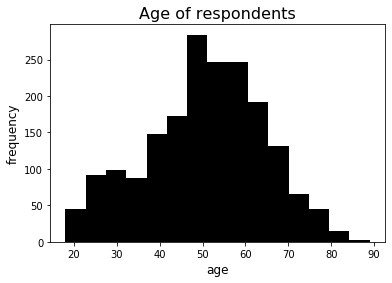

In [32]:
# drop missing age value
df_scpc = df_scpc.dropna(subset=['age'])

# print summary of value counts
plt.hist(df_scpc['age'], bins=15, color='k')
plt.title('Age of respondents', fontsize=16)
plt.xlabel('age', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.show()

In [33]:
# Recode age categories
df_scpc['AgeLevel'] = pd.cut(df_scpc['age'],
                          bins=[0,24,34,44,54,64,100],
                          labels=[1,2,3,4,5,6])
df_scpc['AgeLevel'].value_counts().sort_index()

1     83
2    195
3    279
4    554
5    474
6    287
Name: AgeLevel, dtype: int64

In [34]:
# map age category labels

AgeLevel_label_dict = {
    1: "Less than 25 years",
    2: "25-34 years",
    3: "35-44 years",
    4: "45-54 years",
    5: "55-64 years",
    6: "More than 65"
}

df_scpc['AgeLevel_label'] = df_scpc['AgeLevel'].map(AgeLevel_label_dict)

# confirm results
print(
    'age-related values for the first 5 observations are:\n\n{}\n\n'.format(
    df_scpc[['age', 'AgeLevel', 'AgeLevel_label']].head()
    )
)

AgeLevel_summary = var_summary(df_scpc, 'AgeLevel', 'AgeLevel_label')

age-related values for the first 5 observations are:

    age AgeLevel AgeLevel_label
0  56.0        5    55-64 years
1  64.0        5    55-64 years
2  70.0        6   More than 65
3  63.0        5    55-64 years
4  52.0        4    45-54 years


                             count
AgeLevel AgeLevel_label           
1        Less than 25 years     83
2        25-34 years           195
3        35-44 years           279
4        45-54 years           554
5        55-64 years           474
6        More than 65          287


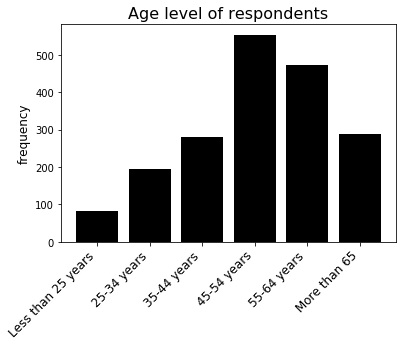

In [35]:
# print summary of value counts
plt.bar(
    [ind[1] for ind in AgeLevel_summary.index],
    AgeLevel_summary.values.ravel(),
    color='k'
)
plt.title('Age level of respondents', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.show()

<a id='race'></a>

## Recode "White" variable and create value labels

[return to top](#top)

**(race)** **Demographic variables**

| Variable    | Description 
|:-------|:---------
|white | Race: white (Y/N)

In [36]:
# Confirm no null values
print(df_scpc['white'].isnull().sum())

print(df_scpc['white'].value_counts(dropna=False))

0
1    1662
0     210
Name: white, dtype: int64


In [37]:
df_scpc['white_label'] = df_scpc['white'].map(binary_label_dict)

white_summary = var_summary(df_scpc, 'white', 'white_label')

                   count
white white_label       
0     No             210
1     Yes           1662


<a id='cols'></a>

## Reorder columns

[return to top](#top)

In [38]:
list(df_scpc.columns)

['r_weight',
 'pa051_a',
 'pa051_b',
 'pa027_a',
 'pa027_b',
 'pa027_c',
 'pa027_d',
 'pa027_e',
 'pa026',
 'age',
 'edu_lhs',
 'edu_hs',
 'edu_sc',
 'edu_c',
 'edu_pgs',
 'inc_lt25',
 'inc_2549',
 'inc_5074',
 'inc_7599',
 'inc_100124',
 'inc_125199',
 'inc_gt200',
 'white',
 'MPay',
 'MPay_label',
 'CPay',
 'CPay_label',
 'MBank',
 'MBank_label',
 'EdLevel',
 'EdLevel_label',
 'IncLevel',
 'IncLevel_label',
 'AgeLevel',
 'AgeLevel_label',
 'white_label']

In [39]:
# set column order for final dataframe 
col_order = [
    'r_weight',
    'pa051_a',
    'pa051_b',
    'pa027_a',
    'pa027_b',
    'pa027_c',
    'pa027_d',
    'pa027_e',
    'pa026',
    'age',
    'edu_lhs',
    'edu_hs',
    'edu_sc',
    'edu_c',
    'edu_pgs',
    'inc_lt25',
    'inc_2549',
    'inc_5074',
    'inc_7599',
    'inc_100124',
    'inc_125199',
    'inc_gt200',
    'MPay_label',
    'CPay_label',
    'MBank_label',
    'EdLevel_label',
    'IncLevel_label',
    'AgeLevel_label',
    'white_label',
    'MPay',
    'CPay',
    'MBank',
    'EdLevel',
    'IncLevel',
    'AgeLevel',
    'white',
]

# reset column order as specified above
df_scpc = df_scpc[col_order]

# check final dataframe
df_scpc.info()
df_scpc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1872 entries, 0 to 2172
Data columns (total 36 columns):
r_weight          1872 non-null float64
pa051_a           1872 non-null float64
pa051_b           1872 non-null float64
pa027_a           1872 non-null float64
pa027_b           1872 non-null float64
pa027_c           1872 non-null float64
pa027_d           1872 non-null float64
pa027_e           1872 non-null float64
pa026             1872 non-null float64
age               1872 non-null float64
edu_lhs           1872 non-null int64
edu_hs            1872 non-null int64
edu_sc            1872 non-null int64
edu_c             1872 non-null int64
edu_pgs           1872 non-null int64
inc_lt25          1872 non-null float64
inc_2549          1872 non-null float64
inc_5074          1872 non-null float64
inc_7599          1872 non-null float64
inc_100124        1872 non-null float64
inc_125199        1872 non-null float64
inc_gt200         1872 non-null float64
MPay_label        1872 

,r_weight,pa051_a,pa051_b,pa027_a,pa027_b,pa027_c,pa027_d,pa027_e,pa026,age,...,IncLevel_label,AgeLevel_label,white_label,MPay,CPay,MBank,EdLevel,IncLevel,AgeLevel,white
0,48.407444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,...,"Less than $25,000",55-64 years,Yes,0,0,0,2,1,5,1
1,19.693514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,...,"$25,000-$49,999 per year",55-64 years,Yes,0,0,0,3,2,5,1
2,27.521273,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,70.0,...,"$25,000-$49,999 per year",More than 65,Yes,0,1,1,3,2,6,1
3,21.771318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,...,"$100,000-$124,999 per year",55-64 years,Yes,0,0,0,3,5,5,1
4,12.004013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,...,"$75,000-$99,999 per year",45-54 years,Yes,0,0,0,5,4,4,1


In [40]:
#########################################
## GENERATE SPLITS
#########################################
np.random.seed(10)

df_train, df_test = train_test_split(
    df_scpc, 
    test_size=0.4,
    random_state = 0, 
    stratify = df_scpc['MPay']
)

print(df_train.shape)
print(df_test.shape)

print(df_train['MPay'].sum(), df_test['MPay'].sum())

(1123, 36)
(749, 36)
24 16


<a id='save'></a>

## Save cleansed model data for EDA and modeling

[return to top](#top)

In [41]:
df_scpc.to_csv(os.path.join(WRITEDIR_ROOT, 'model-data-mobile-payment.csv'), index=False)
df_train.to_csv(os.path.join(WRITEDIR_ROOT, 'model-data-mobile-payment-train.csv'), index=False)
df_test.to_csv(os.path.join(WRITEDIR_ROOT, 'model-data-mobile-payment-test.csv'), index=False)